In [1]:
"""
Data Loading.
"""

'\nData Loading.\n'

In [40]:
import os
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import sys

In [3]:
%%time
stops_path = "./Data/Transit_Stops/Transit_Stops_for_King_County_Metro__transitstop_point.shp"
stops = gpd.read_file(stops_path)

CPU times: total: 39 s
Wall time: 39.1 s


In [4]:
%%time
signals_path = "./Data/Signals/KCM_signals.shp"
signals = gpd.read_file(signals_path)

CPU times: total: 984 ms
Wall time: 968 ms


In [5]:
%%time
kc_streets_path = "./Data/Seattle_Streets/KCM_Streets.shp"
kc_streets = gpd.read_file(kc_streets_path)

CPU times: total: 2min 29s
Wall time: 2min 29s


In [6]:
%%time
kcm_routes_path = "./Data/Routes/Comprehensive_Routes/KCM_Routes.shp"
kcm_routes = gpd.read_file(kcm_routes_path)

CPU times: total: 938 ms
Wall time: 976 ms


In [7]:
%%time
accel_prof_path = "./Data/Accel_Prof/acceleration.csv"
raw_acc_prof = pd.read_csv(accel_prof_path, names=['time[s]', 'accel.[g]'])

CPU times: total: 15.6 ms
Wall time: 9.13 ms


In [8]:
%%time
all_stops = stops.copy()

all_signals = signals['geometry'].reset_index(drop = True)

all_limits = kc_streets[['geometry','SPEED_LIM']]


CPU times: total: 62.5 ms
Wall time: 50.7 ms


(47.0, 47.8)

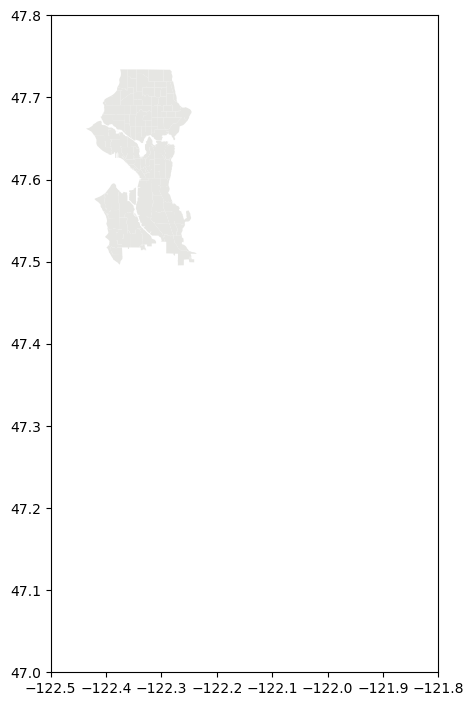

In [11]:
# Display a map of the route overlayed over area data:
# Import area map:
seattle = gpd.read_file("./Data/Census_Tracts_2000/Census_Tracts_2000.shp")

# filter out all 'water' zones in the data for clarity
seattle = seattle[(seattle['WATER'] != 1)]

# set up a figure:
fig, ax = plt.subplots(1, figsize = (5,10))

# Plot the map of the area:
seattle.plot(color="#E6E6E3", ax=ax, zorder = 0)
#all_limits.plot(ax=ax, markersize=1)
#all_signals.plot(ax = ax, c="tab:orange", markersize=1)
ax.set_xlim(-122.5, -121.8)
ax.set_ylim(47, 47.8)

# Landscape elevation +/= Road elevation - Vehicle dynamic models need the road elevation

In [81]:
def separate_period_ridership(rider_df):
    dict_list = {}
    for period in rider_df['Period'].unique():
        period_ridership = rider_df[rider_df['Period']==period]
        sorted_riders = period_ridership.sort_values(by=['InOut','Trip_ID', 'STOP_SEQ', 'STOP_ID'])
        sorted_riders = sorted_riders[['InOut','STOP_SEQ', 'STOP_ID', 'AveOn', 'AveOff', 'AveLd']]
        sorted_riders = sorted_riders.drop_duplicates(subset=['InOut','STOP_SEQ'], keep='first')
        sorted_riders = sorted_riders.drop_duplicates(subset='STOP_ID', keep='first')
        sorted_riders = sorted_riders.reset_index(drop = True)
        sorted_riders['Index'] = sorted_riders.index

        # get the mean ridership change at each stop
        sorted_riders_diff = sorted_riders['AveOn'] - sorted_riders['AveOff']
        
        dict_list[period] = sorted_riders_diff
        
    return dict_list

In [82]:
import os
import Helper_Methods as hm
#variable for route sampling:
route_concat_val = 6 # every 6th point in the data is used

# get the available route shapefiles
route_data_dir = "./Data/Routes/Individual_Routes/"
routefiles_raw = pd.Series(os.listdir(route_data_dir))
routefiles = routefiles_raw[routefiles_raw.apply(lambda x: ('shp' in (x.split("."))[-1]))].reset_index(drop='true')
routefiles = routefiles.apply(lambda x: "{}{}".format(route_data_dir, x))

# get the ridership data
ridership_path = "./Data/Trip_Data/Zon183Unsum.csv"
kcm_ridership = pd.read_csv(ridership_path)

data_dict_list = {}

print("Available Routes:")
for route in routefiles:
    route_shape = gpd.read_file(route)
    route_sampled = route_shape[::route_concat_val]
    route_geometry = route_sampled['geometry']
    route_elevation = route_sampled['Z']
    route_num = (route.split('rt')[-1]).split("_")[0]
    rider_df = kcm_ridership[(kcm_ridership['Route']==int(route_num))]
    rider_sep = separate_period_ridership(rider_df)
    route_stops = hm.get_stops(all_stops, str(route_num))['geometry'].reset_index(drop=True)
    data_dict = {"geometry":route_geometry,
                 "elevation":route_elevation,
                 "ridership":rider_sep,
                 "stops":route_stops}
    data_dict_list[route_num] = data_dict
    print("\t{}".format(route_num))

Available Routes:
	101
	186
	22


In [95]:
seattle_streets = gpd.read_file("./Data/Seattle_Streets/KCM_Streets.shp")

KeyboardInterrupt: 

In [ ]:
data_dict_list['']

In [93]:
all_limits

,geometry,SPEED_LIM
0,"LINESTRING (-122.21422 47.41899, -122.21424 47...",25.0
1,"LINESTRING (-122.30659 47.77427, -122.30597 47...",25.0
2,"LINESTRING (-122.27349 47.45626, -122.27323 47...",25.0
3,"LINESTRING (-122.18814 47.76591, -122.18854 47...",35.0
4,"LINESTRING (-122.10365 47.48038, -122.10364 47...",25.0
...,...,...
143750,"LINESTRING (-122.17258 47.50126, -122.17260 47...",25.0
143751,"LINESTRING (-122.18355 47.40281, -122.18359 47...",25.0
143752,"LINESTRING (-122.16662 47.40982, -122.16654 47...",25.0
143753,"LINESTRING (-122.18380 47.40271, -122.18376 47...",25.0


In [92]:
import RouteMap as rm
for route in data_dict_list.keys():
    route_data = data_dict_list['22']
    route_map = rm.RouteMap(route_data['geometry'],
                            route_data['elevation'],
                            all_limits,
                            route_data['stops'],
                            all_signals,
                            debug = True)
    route_test_map.get_gdf().to_csv('./Data/SAVED_ROUTEMAPS/route_map_{}.csv'.format(route))

DEBUGGER ACTIVE


KeyError: 1

In [ ]:
# Generate a RouteMap with the RouteMap module, passing 
# the route geometry, elevation, limits, route_stops, 
# signals.
route_test_map = rm.RouteMap(route_geometry,
                             route_elevation,
                             limits,
                             route_stops,
                             all_signals,
                             debug = True)


#save the route_map as a csv for future, faster, use. 
route_test_map.get_gdf().to_csv('./Data/SAVED_ROUTEMAPS/route_map_{}.csv'.format(route))

In [74]:
import BusModel as bm
acc_prof_path = "./Data/Accel_Prof/acceleration.csv"
raw_acc_prof = pd.read_csv(acc_prof_path, names=['time[s]', 'accel.[g]'])

# Make a duplicate to alter
a_prof = raw_acc_prof.copy()
# Convert g's to m/s^2 and then drop g's
a_prof['accel.[m/s^2]'] = a_prof['accel.[g]'] * 9.81
a_prof = a_prof.drop(columns = ['accel.[g]'])

default_bus = bm.BusModel(a_prof)